<a href="https://colab.research.google.com/github/WoojinJeonkr/DeepLearning/blob/main/Metric_learning_for_image_similarity_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 이미지 유사성 검색을 위한 척도 학습
- 내용 출처: https://keras.io/examples/vision/metric_learning/
- metric(척도): 학습을 통해 목표를 얼마나 잘(못) 달성했는지를 나타내는 값
- 목표: 학습 계획에 정의된 "유사한" 입력이 서로 가까이 위치하도록 입력을 고차원 공간에 포함할 수 있는 모델을 학습

## 01. Import library

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from collections import defaultdict
from PIL import Image
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow import keras
from tensorflow.keras import layers

## 02. 데이터 다운로드
- 사용 데이터세트: CIFAR-10 dataset

In [2]:
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype("float32") / 255.0
y_train = np.squeeze(y_train)
x_test = x_test.astype("float32") / 255.0
y_test = np.squeeze(y_test)

170508288/170498071 [==============================] - 2s 0us/step


In [3]:
height_width = 32

In [4]:
# 이미지 보여주는 함수 정의
def show_collage(examples):
    box_size = height_width + 2
    num_rows, num_cols = examples.shape[:2]

    collage = Image.new(
        mode="RGB",
        size=(num_cols * box_size, num_rows * box_size),
        color=(250, 250, 250),
    )
    for row_idx in range(num_rows):
        for col_idx in range(num_cols):
            array = (np.array(examples[row_idx, col_idx]) * 255).astype(np.uint8)
            collage.paste(
                Image.fromarray(array), (col_idx * box_size, row_idx * box_size)
            )

    collage = collage.resize((2 * num_cols * box_size, 2 * num_rows * box_size))
    return collage

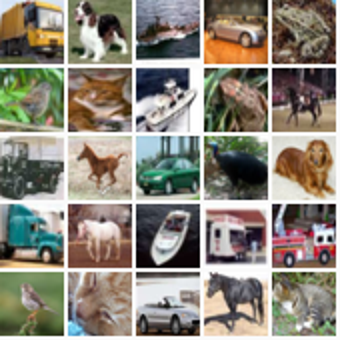

In [5]:
# 이미지 시각화
sample_idxs = np.random.randint(0, 50000, size=(5, 5))
examples = x_train[sample_idxs]
show_collage(examples)

In [6]:
# train 데이터, test 데이터 분할
class_idx_to_train_idxs = defaultdict(list)
for y_train_idx, y in enumerate(y_train):
    class_idx_to_train_idxs[y].append(y_train_idx)

class_idx_to_test_idxs = defaultdict(list)
for y_test_idx, y in enumerate(y_test):
    class_idx_to_test_idxs[y].append(y_test_idx)

In [7]:
num_classes = 10

In [8]:
class AnchorPositivePairs(keras.utils.Sequence):
    def __init__(self, num_batchs):
        self.num_batchs = num_batchs

    def __len__(self):
        return self.num_batchs

    def __getitem__(self, _idx):
        x = np.empty((2, num_classes, height_width, height_width, 3), dtype=np.float32)
        for class_idx in range(num_classes):
            examples_for_class = class_idx_to_train_idxs[class_idx]
            anchor_idx = random.choice(examples_for_class)
            positive_idx = random.choice(examples_for_class)
            while positive_idx == anchor_idx:
                positive_idx = random.choice(examples_for_class)
            x[0, class_idx] = x_train[anchor_idx]
            x[1, class_idx] = x_train[positive_idx]
        return x

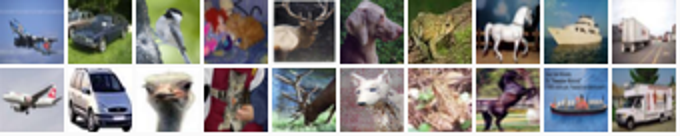

In [9]:
examples = next(iter(AnchorPositivePairs(num_batchs=1)))
show_collage(examples)

## 03. 모델 임베딩

In [10]:
class EmbeddingModel(keras.Model):
    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        anchors, positives = data[0], data[1]

        with tf.GradientTape() as tape:
            anchor_embeddings = self(anchors, training=True)
            positive_embeddings = self(positives, training=True)

            similarities = tf.einsum(
                "ae,pe->ap", anchor_embeddings, positive_embeddings
            )

            temperature = 0.2
            similarities /= temperature
            sparse_labels = tf.range(num_classes)
            loss = self.compiled_loss(sparse_labels, similarities)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        self.compiled_metrics.update_state(sparse_labels, similarities)
        return {m.name: m.result() for m in self.metrics}

In [11]:
# 층 설정
inputs = layers.Input(shape=(height_width, height_width, 3))
x = layers.Conv2D(filters=32, kernel_size=3, strides=2, activation="relu")(inputs)
x = layers.Conv2D(filters=64, kernel_size=3, strides=2, activation="relu")(x)
x = layers.Conv2D(filters=128, kernel_size=3, strides=2, activation="relu")(x)
x = layers.GlobalAveragePooling2D()(x)
embeddings = layers.Dense(units=8, activation=None)(x)
embeddings = tf.nn.l2_normalize(embeddings, axis=-1)

model = EmbeddingModel(inputs, embeddings)

Epoch 1/20
1000/1000 [==============================] - 23s 18ms/step - loss: 2.2648
Epoch 2/20
1000/1000 [==============================] - 13s 13ms/step - loss: 2.1379
Epoch 3/20
1000/1000 [==============================] - 13s 13ms/step - loss: 2.0671
Epoch 4/20
1000/1000 [==============================] - 13s 13ms/step - loss: 2.0067
Epoch 5/20
1000/1000 [==============================] - 13s 13ms/step - loss: 1.9848
Epoch 6/20
1000/1000 [==============================] - 12s 12ms/step - loss: 1.9394
Epoch 7/20
1000/1000 [==============================] - 13s 13ms/step - loss: 1.9269
Epoch 8/20
1000/1000 [==============================] - 13s 13ms/step - loss: 1.8956
Epoch 9/20
1000/1000 [==============================] - 13s 13ms/step - loss: 1.8654
Epoch 10/20
1000/1000 [==============================] - 13s 13ms/step - loss: 1.8262
Epoch 11/20
1000/1000 [==============================] - 13s 13ms/step - loss: 1.8061
Epoch 12/20
1000/1000 [==============================] - 13s 13

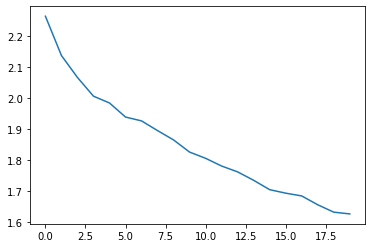

In [12]:
# 모델 컴파일
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)

# 모델 훈련
history = model.fit(AnchorPositivePairs(num_batchs=1000), epochs=20)

plt.plot(history.history["loss"])
plt.show()

## 04. 평가

In [13]:
near_neighbours_per_example = 10

embeddings = model.predict(x_test)
gram_matrix = np.einsum("ae,be->ab", embeddings, embeddings)
near_neighbours = np.argsort(gram_matrix.T)[:, -(near_neighbours_per_example + 1) :]

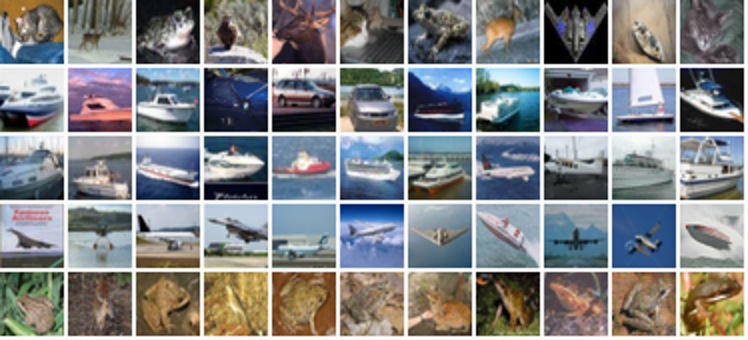

In [14]:
num_collage_examples = 5

examples = np.empty(
    (
        num_collage_examples,
        near_neighbours_per_example + 1,
        height_width,
        height_width,
        3,
    ),
    dtype=np.float32,
)
for row_idx in range(num_collage_examples):
    examples[row_idx, 0] = x_test[row_idx]
    anchor_near_neighbours = reversed(near_neighbours[row_idx][:-1])
    for col_idx, nn_idx in enumerate(anchor_near_neighbours):
        examples[row_idx, col_idx + 1] = x_test[nn_idx]

show_collage(examples)

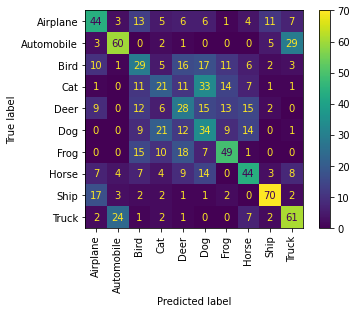

In [15]:
# 혼동 행렬
confusion_matrix = np.zeros((num_classes, num_classes))

for class_idx in range(num_classes):
    # Consider 10 examples.
    example_idxs = class_idx_to_test_idxs[class_idx][:10]
    for y_test_idx in example_idxs:
        # And count the classes of its near neighbours.
        for nn_idx in near_neighbours[y_test_idx][:-1]:
            nn_class_idx = y_test[nn_idx]
            confusion_matrix[class_idx, nn_class_idx] += 1

# 시각화
labels = [
    "Airplane",
    "Automobile",
    "Bird",
    "Cat",
    "Deer",
    "Dog",
    "Frog",
    "Horse",
    "Ship",
    "Truck",
]
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels)
disp.plot(include_values=True, cmap="viridis", ax=None, xticks_rotation="vertical")
plt.show()